## Web Scraper

In [18]:
import pandas as pd
import requests
import cloudscraper
import time, random
from bs4 import BeautifulSoup

Testing on one link before trying to implement a function and apply to all countries of interest

<!DOCTYPE html>
<html class="no-js" data-root="/home/fb/deploy/www" data-version="klecko-" lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="ie=edge" http-equiv="x-ua-compatible"/>
  <meta content="width=device-width, initial-scale=1.0, maximum-scale=2.0" name="viewport">
   <link href="https://cdn.ssref.net/req/202508071" rel="dns-prefetch"/>
   <script>
    /* https://docs.osano.com/hc/en-us/articles/22469433444372-Google-Consent-Mode-v2  */
  window.dataLayer = window.dataLayer ||[];
      function gtag(){dataLayer.push(arguments);}
      gtag('consent','default',{
        'ad_storage':'denied',
        'analytics_storage':'denied',
        'ad_user_data':'denied',
        'ad_personalization':'denied',
        'personalization_storage':'denied',
        'functionality_storage':'granted',
        'security_storage':'granted',
        'wait_for_update': 500
      });
      gtag("set", "ads_data_redaction", true);
   </script>
   <script src="https://cmp.osano.com/16CGnCU8
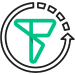
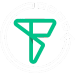

In [25]:
scraper = cloudscraper.create_scraper(delay=15)  
r = scraper.get("https://fbref.com/en/matches/b9e2f869/Morocco-Brazil-March-25-2023-Friendlies-M")
soup = BeautifulSoup(r.text, "html.parser")
print(soup.prettify())

In [27]:
table = soup.find('div', attrs = {'id' : 'div_stats_304635c3_summary'}).find('table').find('tbody')
rows = table.find_all('tr')

# Example to display column elements more clearly
ex_row = rows[0]
for col in ex_row:
    ind = ex_row.index(col)
    print('index', ind, ' ' * (2-len(str(ind))), ' | ', col.text, ' ' * (12-len(col.text)), ' | ', col.get('data-stat'))

index 0    |  Rony           |  player
index 1    |  22             |  shirtnumber
index 2    |  FW             |  position
index 3    |  27-318         |  age
index 4    |  63             |  minutes
index 5    |  0              |  goals
index 6    |  0              |  assists
index 7    |  0              |  pens_made
index 8    |  0              |  pens_att
index 9    |                 |  shots
index 10   |                 |  shots_on_target
index 11   |  1              |  cards_yellow
index 12   |  0              |  cards_red
index 13   |                 |  fouls
index 14   |                 |  fouled
index 15   |                 |  offsides
index 16   |                 |  crosses
index 17   |                 |  tackles_won
index 18   |                 |  interceptions
index 19   |  0              |  own_goals
index 20   |                 |  pens_won
index 21   |                 |  pens_conceded


Finding captincy

In [33]:
soup.find_all('div', attrs={'class':'table_container tabbed current is_setup'})

[]

In [28]:
manager_n_cap = soup.find_all('div', attrs = {'class': 'datapoint'})
cap_name = [manager_n_cap[i].find('a').text for i in [1,3]]

Collect player data for all positions. Save data is stored in a different table. Will pull necessary data from that table if the position is for GK. Otherwise, will just fill the last col data with NA

In [ ]:
goalie_table = soup.find('div', attrs = {'id': 'div_keeper_stats_304635c3'}).find('table').find('tbody')

goal_rows = goalie_table.find_all('tr')

brazil_dat = []
for row in rows:
  name_col = row.find_all('th')
  stat_col = row.find_all('td')
  if len(name_col) > 0:
      name = name_col[0].text.strip()

      position = stat_col[1].text
      mins = stat_col[3].text
      goals = stat_col[4].texta
      assists = stat_col[5].text
      pens_made = stat_col[6].text
      pens_att = stat_col[7].text
      shots = stat_col[8].text
      shots_on_tar = stat_col[9].text
      yellow_cards = stat_col[10].text
      red_cards = stat_col[11].text
      
      if position == 'GK':
        for r in goal_rows:
          goal_stat = r.find_all('td')
          if len(stat_col) > 0:
            goal_against = goal_stat[3].text
            saves = goal_stat[4].text
            save_per = goal_stat[5].text
      else:
        goal_against = 'NA'
        saves = 'NA'
        save_per = 'NA'
      
      if name in cap_name:
        is_cap = 1
      else:
        is_cap = 0


      
  brazil_dat.append([name,mins,position,goals,assists,pens_made,pens_att,shots,shots_on_tar,yellow_cards,red_cards,goal_against,saves,save_per,is_cap])

In [6]:
brazil_dat[-1]

['Wéverton', '90', 'GK', '0', '0', '0', '0', '', '', '0', '0', '2', '', '', 0]

In [42]:
def get_safe(url, scraper, retries=3, base_delay=30):
    for i in range(retries):
        r = scraper.get(url)
        if r.status_code == 200:
            return r
        elif r.status_code == 429:
            wait = base_delay * (2 ** i)
            print(f"Rate limited. Waiting {wait}s before retry {i+1}...")
            time.sleep(wait)
        else:
            time.sleep(1)
    return None

Making the above a function to apply to multiple urls

In [35]:
country_ids = {
    'Brazil': '304635c3'
    }
country_ids.get('Brazil')

'304635c3'

In [ ]:
def match_log_scraper(url, country):
    scraper = cloudscraper.create_scraper(browser={'custom': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)'})  
    r = get_safe(url, scraper)
    soup = BeautifulSoup(r.text, "html.parser")
    
    id = country_ids.get(country)
    
    table = soup.find('div', attrs = {'id' : f'div_stats_{id}_summary'}).find('table').find('tbody')
    rows = table.find_all('tr') 
    
    manager_n_cap = soup.find_all('div', attrs = {'class': 'datapoint'})
    cap_name = [manager_n_cap[i].find('a').text for i in [1,3]]
    
    goalie_table = soup.find('div', attrs = {'id': f'div_keeper_stats_{id}'}).find('table').find('tbody')

    goal_rows = goalie_table.find_all('tr')

    dat = []
    for row in rows:
        name_col = row.find_all('th')
        stat_col = row.find_all('td')
        if len(name_col) > 0:
            name = name_col[0].text.strip()

            position = stat_col[1].text
            mins = stat_col[3].text
            goals = stat_col[4].texta
            assists = stat_col[5].text
            pens_made = stat_col[6].text
            pens_att = stat_col[7].text
            shots = stat_col[8].text
            shots_on_tar = stat_col[9].text
            yellow_cards = stat_col[10].text
            red_cards = stat_col[11].text
            
            if position == 'GK':
                for r in goal_rows:
                    goal_stat = r.find_all('td')
                if len(stat_col) > 0:
                    goal_against = goal_stat[3].text
                    saves = goal_stat[4].text
                    save_per = goal_stat[5].text
            else:
                goal_against = 'NA'
                saves = 'NA'
                save_per = 'NA'
            
            if name in cap_name:
                is_cap = 1
            else:
                is_cap = 0
                
        dat.append([name,mins,position,goals,assists,pens_made,pens_att,shots,shots_on_tar,yellow_cards,red_cards,goal_against,saves,save_per,is_cap])
    
    return dat

In [41]:
match_log_scraper("https://fbref.com/en/matches/b9e2f869/Morocco-Brazil-March-25-2023-Friendlies-M",'Brazil')

Rate limited. Waiting 15s before retry 1...


KeyboardInterrupt: 

In [ ]:
brazil_urls = ['https://fbref.com/en/matches/4928c81b/Brazil-Bolivia-October-9-2020-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/5dcbc304/Peru-Brazil-October-13-2020-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/240cd6ea/Brazil-Venezuela-November-13-2020-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/200f1977/Uruguay-Brazil-November-17-2020-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/426bc821/Brazil-Ecuador-June-4-2021-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/9476d029/Paraguay-Brazil-June-8-2021-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/2bbbdd2e/Brazil-Venezuela-June-13-2021-Copa-America',
        'https://fbref.com/en/matches/e822cbef/Brazil-Peru-June-17-2021-Copa-America',
        'https://fbref.com/en/matches/781f726c/Brazil-Colombia-June-23-2021-Copa-America',
        'https://fbref.com/en/matches/9dbb8fff/Brazil-Ecuador-June-27-2021-Copa-America',
        'https://fbref.com/en/matches/f73d3978/Brazil-Chile-July-2-2021-Copa-America',
        'https://fbref.com/en/matches/17ac9b9b/Brazil-Peru-July-5-2021-Copa-America',
        'https://fbref.com/en/matches/1309eaf0/Argentina-Brazil-July-10-2021-Copa-America',
        'https://fbref.com/en/matches/86e9755d/Chile-Brazil-September-2-2021-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/412055d2/Brazil-Peru-September-9-2021-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/9a5d9c01/Venezuela-Brazil-October-7-2021-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/397cba16/Colombia-Brazil-October-10-2021-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/48f7c36a/Brazil-Uruguay-October-14-2021-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/4f932221/Brazil-Colombia-November-11-2021-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/56b8bba4/Argentina-Brazil-November-16-2021-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/2115c0c8/Ecuador-Brazil-January-27-2022-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/8ce68c2d/Brazil-Paraguay-February-1-2022-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/d41effec/Brazil-Chile-March-24-2022-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/af491e1e/Bolivia-Brazil-March-29-2022-WCQ----CONMEBOL-M',
        'https://fbref.com/en/matches/1ddc6610/Korea-Republic-Brazil-June-2-2022-Friendlies-M',
        'https://fbref.com/en/matches/f3f835c8/Japan-Brazil-June-6-2022-Friendlies-M',
        'https://fbref.com/en/matches/756dc6e1/Brazil-Ghana-September-23-2022-Friendlies-M',
        'https://fbref.com/en/matches/963b2d1a/Brazil-Tunisia-September-27-2022-Friendlies-M',
        'https://fbref.com/en/matches/457c3fcf/Brazil-Serbia-November-24-2022-World-Cup',
        'https://fbref.com/en/matches/459240ee/Brazil-Switzerland-November-28-2022-World-Cup',
        'https://fbref.com/en/matches/5a2cc3c5/Cameroon-Brazil-December-2-2022-World-Cup',
        'https://fbref.com/en/matches/bc6994e8/Brazil-Korea-Republic-December-5-2022-World-Cup',
        'https://fbref.com/en/matches/bb30147d/Croatia-Brazil-December-9-2022-World-Cup',
        'https://fbref.com/en/matches/b9e2f869/Morocco-Brazil-March-25-2023-Friendlies-M',
        'https://fbref.com/en/matches/416b9e83/Brazil-Guinea-June-17-2023-Friendlies-M',
        'https://fbref.com/en/matches/9e972c43/Brazil-Senegal-June-20-2023-Friendlies-M',
        'https://fbref.com/en/matches/5eccc784/England-Brazil-March-23-2024-Friendlies-M',
        'https://fbref.com/en/matches/f47f2579/Spain-Brazil-March-26-2024-Friendlies-M',
        'https://fbref.com/en/matches/df95da27/Mexico-Brazil-June-8-2024-Friendlies-M',
        'https://fbref.com/en/matches/174bf942/United-States-Brazil-June-12-2024-Friendlies-M',
        'https://fbref.com/en/matches/9e7417ae/Brazil-Costa-Rica-June-24-2024-Copa-America',
        'https://fbref.com/en/matches/db2faedf/Paraguay-Brazil-June-28-2024-Copa-America',
        'https://fbref.com/en/matches/438b034c/Brazil-Colombia-July-2-2024-Copa-America',
        'https://fbref.com/en/matches/c63a9e9c/Uruguay-Brazil-July-6-2024-Copa-America'
        ]

all_brazil_data = []

for i, url in enumerate(brazil_urls, 1):
    print(f"Fetching {i}/{len(brazil_urls)}: {url}")
    r = get_safe(url, scraper)
    if not r:
        continue
    
    soup = BeautifulSoup(r.text, "html.parser")
    match_data = match_log_scraper(soup, 'Brazil')
    all_brazil_data.extend(match_data)

    # Randomized sleep between requests (prevent pattern detection)
    sleep_time = random.uniform(20, 45)
    print(f"Sleeping {sleep_time:.1f}s before next request...")
    time.sleep(sleep_time)


df = pd.DataFrame(all_brazil_data)
df.head()

Rate limited. Waiting 5s before retry 1...
Rate limited. Waiting 10s before retry 2...
Rate limited. Waiting 20s before retry 3...


KeyboardInterrupt: 